## Import library

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import string

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from sklearn.metrics import confusion_matrix, classification_report

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

## Data Loading

In [2]:
data = pd.read_csv('/content/IMDB Dataset.csv')

## Text Preprocessing

In [3]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [4]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'https:\/\/[^\s]+ | www.[^\s]+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub('\n', ' ', text)
    text = re.sub(r'\w*\d\w*', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    text = ' '.join(tokens)
    return text

In [27]:
data['review'] = data['review'].apply(preprocess_text)
data.head()

,review,sentiment
0,one reviewer mentioned watching oz episode you...,1
1,wonderful little production filming technique ...,1
2,thought wonderful way spend time hot summer we...,1
3,basically there family little boy jake think t...,0
4,petter matteis love time money visually stunni...,1


In [6]:
data.shape

(50000, 2)

In [7]:
data.sentiment.value_counts()

,count
sentiment,
positive,25000
negative,25000


In [8]:
data.isna().sum()

,0
review,0
sentiment,0


### Tokenization and Padding

In [9]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(data['review'])
sequences = tokenizer.texts_to_sequences(data['review'])
padded_sequences = pad_sequences(sequences, maxlen=100)

In [10]:
def convert_sentiment(sentiment):
    if sentiment == 'positive':
        return 1
    else:
        return 0

data['sentiment'] = data['sentiment'].apply(convert_sentiment)

### Splitting Data

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, data['sentiment'], test_size=0.2)


## Model LSTM

In [12]:
model = Sequential([
    Embedding(5000, 64),
    LSTM(64),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [13]:
model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 80s 62ms/step - accuracy: 0.7753 - loss: 0.4572 - val_accuracy: 0.8596 - val_loss: 0.3261
Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 76s 57ms/step - accuracy: 0.8884 - loss: 0.2754 - val_accuracy: 0.8715 - val_loss: 0.3049
Epoch 3/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 79s 55ms/step - accuracy: 0.9119 - loss: 0.2216 - val_accuracy: 0.8716 - val_loss: 0.3249
Epoch 4/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 78s 52ms/step - accuracy: 0.9295 - loss: 0.1789 - val_accuracy: 0.8732 - val_loss: 0.3396
Epoch 5/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 85s 55ms/step - accuracy: 0.9434 - loss: 0.1487 - val_accuracy: 0.8585 - val_loss: 0.4118


In [14]:
loss, accuracy = model.evaluate(X_test, y_test)
print('Accuracy:', accuracy)


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.8644 - loss: 0.3943
Accuracy: 0.8585000038146973


In [16]:
y_pred = model.predict(X_test)
threshold = 0.5
y_pred_classes = (y_pred > threshold).astype(int)

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step


In [17]:
conf_matrix = confusion_matrix(y_test, y_pred_classes)

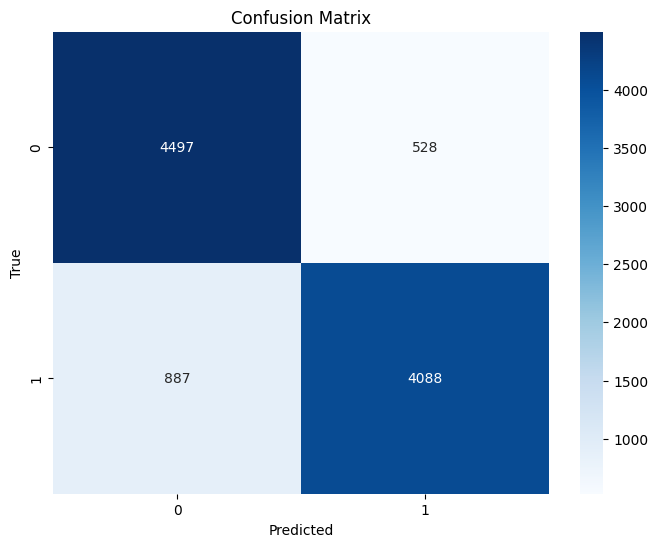

In [18]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [19]:
print(classification_report(y_test, y_pred_classes))

              precision    recall  f1-score   support

           0       0.84      0.89      0.86      5025
           1       0.89      0.82      0.85      4975

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



## Model RNN

In [20]:
from keras.layers import SimpleRNN

modelRNN = Sequential([
  Embedding(5000, 64),
  SimpleRNN(64),
  Dense(1, activation='sigmoid')
])

modelRNN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [21]:
modelRNN.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 37s 28ms/step - accuracy: 0.6401 - loss: 0.6070 - val_accuracy: 0.7354 - val_loss: 0.5281
Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 28ms/step - accuracy: 0.8321 - loss: 0.3855 - val_accuracy: 0.8326 - val_loss: 0.4061
Epoch 3/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 28ms/step - accuracy: 0.8250 - loss: 0.3864 - val_accuracy: 0.7315 - val_loss: 0.5574
Epoch 4/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 34s 27ms/step - accuracy: 0.7943 - loss: 0.4521 - val_accuracy: 0.7892 - val_loss: 0.4748
Epoch 5/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 35s 28ms/step - accuracy: 0.8624 - loss: 0.3222 - val_accuracy: 0.7947 - val_loss: 0.4919


In [22]:
y_predRNN = modelRNN.predict(X_test)
threshold = 0.5
y_pred_classesr = (y_predRNN > threshold).astype(int)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


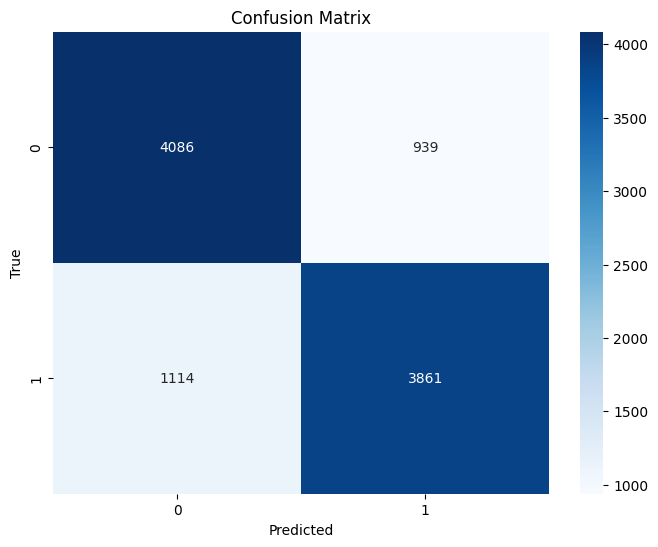

In [23]:
conf_matrix = confusion_matrix(y_test, y_pred_classesr)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [24]:
print(classification_report(y_test, y_pred_classesr))

              precision    recall  f1-score   support

           0       0.79      0.81      0.80      5025
           1       0.80      0.78      0.79      4975

    accuracy                           0.79     10000
   macro avg       0.80      0.79      0.79     10000
weighted avg       0.80      0.79      0.79     10000



## Sentiment Prediction

In [25]:
review = "Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them."
review = preprocess_text(review)

review_sequence = tokenizer.texts_to_sequences([review])
review_padded = pad_sequences(review_sequence, maxlen=100)


prediction_1 = model.predict(review_padded)
print(prediction_1)
if prediction_1 > 0.5:
    print('positive')
else:
    print('negative')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
[[0.01398673]]
negative


In [26]:
review_2 = "A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only has got all the polari but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master's of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional 'dream' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell's murals decorating every surface) are terribly well done."
review_2 = preprocess_text(review_2)

review_sequence = tokenizer.texts_to_sequences([review_2])
review_padded = pad_sequences(review_sequence, maxlen=100)


prediction_2 = model.predict(review_padded)
print(prediction_2)
if prediction_2 > 0.5:
    print('positive')
else:
    print('negative')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
[[0.99068695]]
positive
